In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
from pathlib import Path
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from kerastuner import tuners
from kerastuner import HyperParameters

from tqdm.auto import tqdm

import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')
dataset_dir = data_dir / 'dataset_v6'

train_data_dir = dataset_dir / 'training'
val_data_dir = dataset_dir / 'validation'

tokenizer_path = dataset_dir / "tokenizer.json"

log_dir = data_dir / 'log'
log_dir.mkdir(exist_ok=True, parents=True)

model_dir = data_dir / 'model'
model_dir.mkdir(exist_ok=True, parents=True)
  
# Get tokenizer
with open(tokenizer_path) as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())

In [2]:
# Build the dataset
def make_dataset(data_dir, tokenizer, batch_size, image_size=None, shuffle=False, n=None):

  fnames = [str(p) for p in data_dir.glob("*.tfrecord")]
  dataset = tf.data.TFRecordDataset(fnames)
  if n:
    dataset = dataset.take(n)
  if shuffle:
      dataset = dataset.shuffle(buffer_size=2048)
      
  # We could infer it from the dataset but here it's hard-coded.
  max_len_word = 10
      
  decode_fn = captchanet.decode_data(tokenizer, max_len_word, image_size=image_size)
  dataset = dataset.map(map_func=decode_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

batch_size = 20
image_size = (224, 224)
train_dataset = make_dataset(train_data_dir, tokenizer, batch_size=batch_size, image_size=image_size, shuffle=True)
val_dataset = make_dataset(val_data_dir, tokenizer, batch_size=batch_size, image_size=image_size, shuffle=False)

W0714 01:26:25.566512 139921008002880 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [3]:
# Load model v5 with its weights instead of building a new model.
model_v5_path = model_dir / 'v5'
model = tf.keras.models.load_model(str(model_v5_path / 'model'))

In [4]:
# Callbacks
callbacks = []

log_path = log_dir / datetime.datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
log_path.mkdir(exist_ok=True)

tb = captchanet.LRTensorBoard(log_dir=str(log_path), write_images=False, write_graph=True)
#callbacks.append(tb)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)
callbacks.append(reduce_lr)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=10)
#callbacks.append(early_stop)

tqdm_progress = captchanet.TQDMCallback()
callbacks.append(tqdm_progress)

csv_logger = tf.keras.callbacks.CSVLogger(str(log_path / 'log.csv'))
callbacks.append(csv_logger)

def solve_rate(true_labels, predicted_labels):
  """Compute the number of word correctly predicted.
  """
  t1 = tf.argmax(true_labels, axis=2)
  t2 = tf.argmax(predicted_labels, axis=2)
  success_count = tf.math.reduce_all(tf.equal(t1, t2), axis=1)
  success_count = tf.cast(success_count, dtype=tf.int32)
  rate = tf.math.reduce_sum(success_count) / tf.shape(success_count)[0]
  return rate

adam_params = {}
adam_params['learning_rate'] = 1e-3
adam_params['amsgrad'] = True
optimizer = tf.keras.optimizers.Adam(**adam_params)

model.compile(optimizer=optimizer, loss=model.loss, metrics=['accuracy'])

In [ ]:
n_epochs = 200
model.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=callbacks, verbose=0)

W0714 01:27:08.950244 139921008002880 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Save model
model_path = model_dir / 'v6'
model_path.mkdir(exist_ok=True)
model.save(str(model_path / 'model'))

# Save tokenizer
with open(model_path / tokenizer_path.name, 'w') as f:
  f.write(tokenizer.to_json())

# Save history
history = pd.DataFrame(model.history.history)
history_path = model_path / 'history.csv'
history.to_csv(str(history_path), index=False)

# Pack and zip the model directory
import shutil
archive_path = model_dir / model_path.stem
shutil.rmtree(model_path / '.ipynb_checkpoints', ignore_errors=True)
shutil.make_archive(archive_path, 'zip', root_dir=model_path)

In [ ]:
# Check history
history = pd.read_csv(history_path)

n = 3
size = 3.5
ncols = 3
w_h_scale = 2
figsize = (ncols * size * w_h_scale, size)
fig, axs = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=figsize)
axs = axs.flatten()

axs[0].plot(history['val_accuracy'], label='val_accuracy')
axs[0].plot(history['accuracy'], label='accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history['val_loss'], label='val_loss')
axs[1].plot(history['loss'], label='loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

axs[2].plot(history['lr'])
axs[2].set_xlabel('epoch')

fig.savefig(model_path / 'history.png')

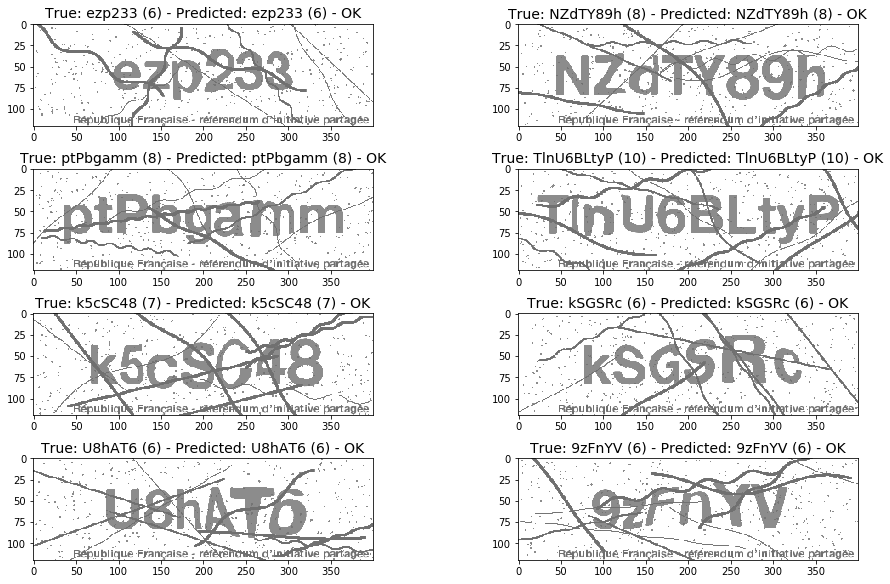

In [8]:
loaded_model = model

# Perform prediction
model_image_size = (224, 224)
n  = 8
fnames = [str(p) for p in val_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, image_size=model_image_size, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

labels = loaded_model(images)

# Decode
labels = labels.numpy().argmax(axis=2)
predicted_words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
predicted_words = [word.replace(' ', '') for word in predicted_words]

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8').replace('0', '') for w in words]

size = 2
ncols = 2
nrows = n // ncols
ratio = original_images.shape[2] / original_images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, predicted_word, ax in zip(original_images, words, predicted_words, axs):
  ax.imshow(image)
  
  mark = 'OK' if predicted_word == word else 'WRONG'
  text = f'True: {word} ({len(word)})'
  text += f' - Predicted: {predicted_word} ({len(predicted_word)})'
  text += f" - {mark}"
  ax.set_title(text, fontsize=14)
  
fig.savefig(model_path / 'example_prediction.png')